# Hydraulic head change training 

## Preliminaries

In [1]:
# Imports
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split


import plotly.graph_objects as go

## Custom modules
import utils.head_change_utils as utils
import utils.governing_functions as gvf

# Open the file and load the file
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
simulations_path = yaml_data['simulations_path']
inp_path =  yaml_data['inp_path']
rain_path = simulations_path + '\\block' + '\\block.dat'
heads_path = simulations_path + '\\block' + '\\rainblock_head_TuindorpRP.pk'

## Read data from rainfall and hydraulic head

In [2]:
#Rainfall
rainfall_raw_data = utils.get_rain_in_pandas(rain_path)

#Hydraulic head
head_raw_data = utils.get_info_from_pickle(heads_path)
head_raw_data.columns = head_raw_data.columns.str.replace("_Hydraulic_head", "")
head_raw_data.columns = head_raw_data.columns.str.replace("node_", "")

In [3]:
#Periods without rain
# dry_periods_index = rainfall_raw_data[rainfall_raw_data['value']==0].index
dry_periods_index = [[12, 13, 14, 15, 16, 17],          #First dry period
                     [24, 25, 26, 27, 28, 29, 30, 31,], #Second dry period
                     [38, 39, 40, 41, 42, 43, 44, 45],  #Third dry period
                     [52, 53, 54, 55, 56, 57],          #Fourth dry period
                     [64, 65, 66, 67, 68, 69],          #Fifth dry period
                     [76, 77, 78, 79, 80, 81, 82, 83, 84] #Last dry period
                    ]

In [4]:
h0_values = []
h1_values = []

for dry_period in dry_periods_index:
    heads_no_rain = head_raw_data.iloc[list(dry_period), :]
    initial_heads, next_heads = utils.get_h0_h1_couples(heads_no_rain)
    
    h0_values.extend(initial_heads)
    h1_values.extend(next_heads)



## Separate samples in training/validation/testing

In [5]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(h0_values, h1_values,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

## Data preprocessing

### Normalization

In [6]:
max, min = utils.get_max_and_min(X_train + y_train) #It considers all heads with the same scaling

normalized_x = utils.normalize_sample_values(X_train, max, min)
normalized_y = utils.normalize_sample_values(y_train, max, min)

### Visualization

In [7]:
# For a single node
single_node_x = []
single_node_y = []
node_name = 'j_90492'
length_database = len(normalized_x) #same as y_train

for i in range(length_database):
    single_node_x.append(normalized_x[i][node_name])
    single_node_y.append(normalized_y[i][node_name])



In [8]:
fig = go.Figure()
scatter_one_node_x_y=utils.get_scatter_trace(single_node_x, single_node_y)
fig.add_trace(scatter_one_node_x_y)

fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.update_layout(
    width = 500,
    height = 500,
    title = "%s Head changes" % (node_name)
)

fig.update_layout(
        shapes=[
            dict(
                type= 'line',
                y0= 0, 
                y1= 1, 
                x0= 0, 
                x1= 1
            )
        ])

fig.show()

## Model

### Model definition

In [9]:
inp_lines = utils.get_lines_from_textfile(inp_path)
G = utils.inp_to_G(inp_lines)

There are no [STORAGE]
 in the file
The file does not have pumps. A handled exception occured because of '[PUMPS]\n'
The file does not have orifices. A handled exception occured because of '[ORIFICES]\n'
The file does not have weirs. A handled exception occured because of '[WEIRS]\n'


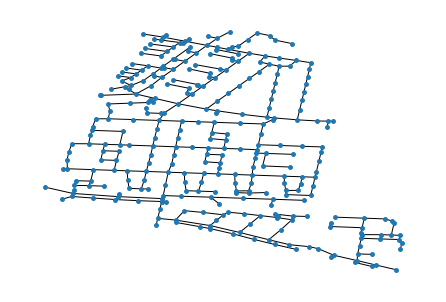

In [10]:
#Draw graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos = pos, node_size=15)

## Dynamic emulator

In [11]:
original_h0 = normalized_x
original_min = nx.get_node_attributes(G, 'elevation')
original_A_catch = nx.get_node_attributes(G, 'area_subcatchment')

pos = nx.get_node_attributes(G, 'pos')

In [12]:
def to_pd_rows(timestep, h):
    rows = [[timestep, node, depth - float(original_min[node]), pos[node][0], pos[node][1]] for node, depth in h.items()]
    return rows

In [14]:
h = original_h0[0]
h_pd = to_pd_rows(0,h) #pd.DataFrame.from_dict(h, orient='index', columns=['Depth'])

df = pd.DataFrame(h_pd, columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord'])

pump_state = 0
for time in range(1):
    
    h= gvf.difussion(G,h)#, original_min, time, pump_state)
    new_h_rows = pd.DataFrame(to_pd_rows(time+1,h), columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord'])
   
    df = df.append(new_h_rows)

C:\Users\agarzondiaz\AppData\Local\Temp\ipykernel_24204\3744017207.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [18]:
df.tail(10)

,Time,Node,Depth,x_coord,y_coord
308,1,j_91275,0.458727,137685.439,458041.605
309,1,j_91276,0.982296,137717.629,458003.985
310,1,j_91277,0.432451,137677.129,458018.595
311,1,j_91278,0.735832,137705.949,457982.035
312,1,j_91279,0.439010,137668.719,457995.505
313,1,j_91292,0.769714,137760.379,458025.285
314,1,j_91293,1.314146,137729.319,457966.375
315,1,j_91294,0.562273,137709.789,457930.205
316,1,j_90552,0.000000,137490.379,457336.995
317,1,j_90431,0.000000,137593.049,457787.795


In [20]:
import plotly.express as px
net = px.scatter(df, x="x_coord", y="y_coord", size="Depth", animation_frame="Time", size_max=20, hover_name="Node",width=800, height=800)

net.show()

### Model training

### Model validation

### Model testing

## Predictions visualization

## Export model

# Scratchpad

In [16]:
G.edges[('j_9006F', 'j_90686')]

{'name': 'c_906862',
 'length': '45.218733',
 'roughness': '0.012858',
 'in_offset': '0.000000',
 'out_offset': '0.000000',
 'shape': 'EGG',
 'geom_1': '0.600000',
 'geom_2': '0.400000'}